In [1]:
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import backend as K 
from tensorflow.keras.datasets import mnist 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, LeakyReLU, Input, ReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np 
from PIL import Image
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
def preprocess_image(image_path, inverted=False):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(28,28), color_mode = "grayscale")
    img_arr =  tf.keras.preprocessing.image.img_to_array(img)
    img_arr = img_arr.astype("float32")
    if inverted == True: 
        img_arr = 255 - img_arr
    img_arr = img_arr / 255
    img_arr = img_arr.reshape(1, 28, 28, 1)
    return img_arr

In [3]:
def show_max_pixel(array, i): 
    random_image = array[i]
    return random_image.max()

In [4]:
def plot_image(array, i, labels): 
    plt.imshow(np.squeeze(array[i]))
    plt.title(f"Label: {str(labels[i])}")
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [5]:
def data_generator(images, labels, batch_size, datagen):
    num_samples = len(images)
    while True:
        indices = tf.range(num_samples)
        indices = tf.random.shuffle(indices)
        for i in range(0, num_samples, batch_size):
            batch_indices = indices[i:i+batch_size]
            batch_images = images[batch_indices]
            batch_labels = labels[batch_indices]
            augmented_images, augmented_labels = next(datagen.flow(batch_images, batch_labels, batch_size=batch_size))
            yield augmented_images, augmented_labels

In [6]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [7]:
# Calculate the number of validation samples
num_validation_samples = int(len(train_images) * 0.1)

# Generate a list of random indices
indices = list(range(len(train_images)))
random.shuffle(indices)

# Take the first num_validation_samples indices for validation
val_indices = indices[:num_validation_samples]

# Extract validation images and labels
val_images = train_images[val_indices]
val_labels = train_labels[val_indices]

# Remove the validation samples from the training set
train_images = np.delete(train_images, val_indices, axis=0)
train_labels = np.delete(train_labels, val_indices, axis=0)


In [8]:
num_classes = 10
img_height = 28
img_width = 28
# lets reshape the training and testing images data to add a dimension to account for color (grayscale) 
train_images = train_images.reshape(train_images.shape[0], img_height, img_width, 1)
test_images = test_images.reshape(test_images.shape[0], img_height, img_width, 1)
val_images = val_images.reshape(val_images.shape[0], img_height, img_width, 1)
# lets make sure that the values of each pixel fall in the range of (0,1)
train_images = train_images / 255
test_images = test_images / 255
val_images = val_images / 255
# lets use one hot encoding to prevent the labels of our data from impeding the ability of the model
train_labels = keras.utils.to_categorical(train_labels, num_classes)
test_labels = keras.utils.to_categorical(test_labels, num_classes)
val_labels = keras.utils.to_categorical(val_labels, num_classes)

In [9]:
epochs = 20
dropout_rate = 0.4
training_rate = 0.001 # rmsprop and adam defualt = 0.001
optimizer = tf.keras.optimizers.RMSprop(learning_rate=training_rate)
loss_method = "categorical_crossentropy" 
required_metrics = ["accuracy"]
batch_size = 32

In [10]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False
)

train_data_generator = data_generator(train_images, train_labels, batch_size, datagen)
val_data_generator = data_generator(val_images, val_labels, batch_size, datagen)

In [11]:
model = Sequential()
model.add(Input(shape=(28, 28, 1)))
# First Convolutional Block
model.add(Conv2D(32, (3, 3)))
model.add(ReLU())
model.add(BatchNormalization())


# Second Convolutional Block
model.add(Conv2D(64, (3, 3)))
model.add(ReLU())
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())

# Third Convolutional Block
model.add(Conv2D(128, (3, 3)))
model.add(ReLU())
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3)))
model.add(ReLU())
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())


# Flatten the 3D output to 1D tensor
model.add(Flatten())
model.add(BatchNormalization())

# First Dense Block
model.add(Dense(512))
model.add(ReLU())
model.add(BatchNormalization())
model.add(Dropout(dropout_rate))

# Output Layer
model.add(Dense(10, activation='softmax'))  # Assuming 10 classes for output

In [12]:
# Now Compile the model 
model.compile(loss=loss_method, optimizer=optimizer, metrics=required_metrics)
history =  model.fit(train_data_generator,
                     steps_per_epoch=len(train_images)//batch_size,
                     epochs=epochs,
                     validation_data=val_data_generator,
                     validation_steps=len(val_images)//batch_size)

Epoch 1/20
1687/1687 ━━━━━━━━━━━━━━━━━━━━ 53s 30ms/step - accuracy: 0.8898 - loss: 0.3775 - val_accuracy: 0.9833 - val_loss: 0.0526
Epoch 2/20
1687/1687 ━━━━━━━━━━━━━━━━━━━━ 55s 33ms/step - accuracy: 0.9743 - loss: 0.0830 - val_accuracy: 0.9873 - val_loss: 0.0393
Epoch 3/20
1687/1687 ━━━━━━━━━━━━━━━━━━━━ 54s 32ms/step - accuracy: 0.9800 - loss: 0.0653 - val_accuracy: 0.9898 - val_loss: 0.0335
Epoch 4/20
1687/1687 ━━━━━━━━━━━━━━━━━━━━ 54s 32ms/step - accuracy: 0.9829 - loss: 0.0606 - val_accuracy: 0.9894 - val_loss: 0.0397
Epoch 5/20
1687/1687 ━━━━━━━━━━━━━━━━━━━━ 56s 33ms/step - accuracy: 0.9856 - loss: 0.0488 - val_accuracy: 0.9903 - val_loss: 0.0289
Epoch 6/20
1687/1687 ━━━━━━━━━━━━━━━━━━━━ 57s 34ms/step - accuracy: 0.9861 - loss: 0.0465 - val_accuracy: 0.9916 - val_loss: 0.0335
Epoch 7/20
1687/1687 ━━━━━━━━━━━━━━━━━━━━ 54s 32ms/step - accuracy: 0.9862 - loss: 0.0475 - val_accuracy: 0.9933 - val_loss: 0.0311
Epoch 8/20
1687/1687 ━━━━━━━━━━━━━━━━━━━━ 55s 32ms/step - accuracy: 0.9882 -

In [13]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=2)

313/313 - 3s - 8ms/step - accuracy: 0.9946 - loss: 0.0246


In [14]:
# Lets make a string to summarize our model's features and evaluation metrics
from IPython.display import Markdown
final_train_loss = history.history['loss'][-1]
final_train_accuracy = history.history['accuracy'][-1]
learning_rate_str = format(training_rate, "f").rstrip('0').rstrip('.')
evaluation = f"""
**Num Epochs:** {epochs}<br>
**Batch Size:** {batch_size}<br>
**Training Rate:** {learning_rate_str}<br>
**Dropout Rate:** {dropout_rate}<br>
**Loss Method:** {loss_method}<br>
**Final Training Accuracy:** {final_train_accuracy*100:.2f}%<br>
**Final Training Loss:** {final_train_loss*100:.2f}%<br>
**Test Accuracy:** {test_accuracy*100:.2f}%<br>
**Test Loss:** {test_loss*100:.2f}%
"""

In [15]:
Markdown(evaluation)


**Num Epochs:** 20<br>
**Batch Size:** 32<br>
**Training Rate:** 0.001<br>
**Dropout Rate:** 0.4<br>
**Loss Method:** categorical_crossentropy<br>
**Final Training Accuracy:** 99.10%<br>
**Final Training Loss:** 3.26%<br>
**Test Accuracy:** 99.46%<br>
**Test Loss:** 2.46%


In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 26, 26, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 12, 12, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 10, 10, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 10, 10, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 4, 4, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_4 (ReLU)                       │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 512)                 │           2,0

 Total params: 2,606,422 (9.94 MB)

 Trainable params: 1,300,298 (4.96 MB)

 Non-trainable params: 5,824 (22.75 KB)

 Optimizer params: 1,300,300 (4.96 MB)

In [17]:
# preprocess test images
test_0w = preprocess_image("./final_test_images/0w.jpg")
test_0d = preprocess_image("./final_test_images/0d.png")
test_0w_inv = preprocess_image("./final_test_images/0w.jpg", inverted=True)
test_0d_inv = preprocess_image("./final_test_images/0d.png", inverted=True)

test_1w = preprocess_image("./final_test_images/1w.jpg")
test_1d = preprocess_image("./final_test_images/1d.png")
test_1w_inv = preprocess_image("./final_test_images/1w.jpg", inverted=True)
test_1d_inv = preprocess_image("./final_test_images/1d.png", inverted=True)

test_2w = preprocess_image("./final_test_images/2w.jpg")
test_2d = preprocess_image("./final_test_images/2d.png")
test_2w_inv = preprocess_image("./final_test_images/2w.jpg", inverted=True)
test_2d_inv = preprocess_image("./final_test_images/2d.png", inverted=True)

test_3w = preprocess_image("./final_test_images/3w.jpg")
test_3d = preprocess_image("./final_test_images/3d.png")
test_3w_inv = preprocess_image("./final_test_images/3w.jpg", inverted=True)
test_3d_inv = preprocess_image("./final_test_images/3d.png", inverted=True)

test_4w = preprocess_image("./final_test_images/4w.jpg")
test_4d = preprocess_image("./final_test_images/4d.png")
test_4w_inv = preprocess_image("./final_test_images/4w.jpg", inverted=True)
test_4d_inv = preprocess_image("./final_test_images/4d.png", inverted=True)

test_5w = preprocess_image("./final_test_images/5w.jpg")
test_5d = preprocess_image("./final_test_images/5d.png")
test_5w_inv = preprocess_image("./final_test_images/5w.jpg", inverted=True)
test_5d_inv = preprocess_image("./final_test_images/5d.png", inverted=True)

test_6w = preprocess_image("./final_test_images/6w.jpg")
test_6d = preprocess_image("./final_test_images/6d.png")
test_6w_inv = preprocess_image("./final_test_images/6w.jpg", inverted=True)
test_6d_inv = preprocess_image("./final_test_images/6d.png", inverted=True)

test_7w = preprocess_image("./final_test_images/7w.jpg")
test_7d = preprocess_image("./final_test_images/7d.png")
test_7w_inv = preprocess_image("./final_test_images/7w.jpg", inverted=True)
test_7d_inv = preprocess_image("./final_test_images/7d.png", inverted=True)

test_8w = preprocess_image("./final_test_images/8w.jpg")
test_8d = preprocess_image("./final_test_images/8d.png")
test_8w_inv = preprocess_image("./final_test_images/8w.jpg", inverted=True)
test_8d_inv = preprocess_image("./final_test_images/8d.png", inverted=True)

test_9w = preprocess_image("./final_test_images/9w.jpg")
test_9d = preprocess_image("./final_test_images/9d.png")
test_9w_inv = preprocess_image("./final_test_images/9w.jpg", inverted=True)
test_9d_inv = preprocess_image("./final_test_images/9d.png", inverted=True)

Predicted Label:  0


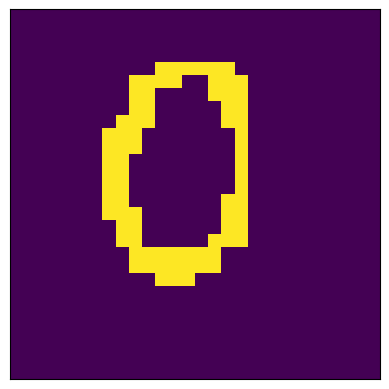

[[9.9999452e-01 1.6509186e-07 4.7609183e-07 7.6556532e-08 5.1408287e-09
  1.3784770e-06 4.3185091e-07 1.2229109e-06 1.1236517e-06 6.6552900e-07]]


In [18]:
# test 0d inverted
image_predict = model.predict(test_0d_inv, verbose=0)
print("Predicted Label: ", np.argmax(image_predict))
plt.imshow(np.squeeze(test_0d_inv))
plt.xticks([])
plt.yticks([])
plt.show()
print(image_predict)

Predicted Label:  1


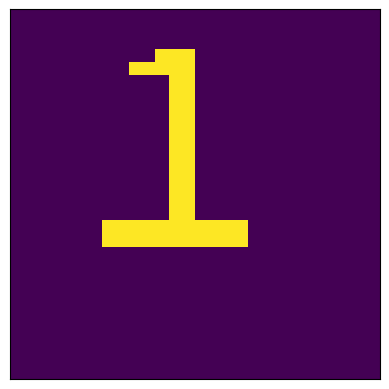

[[3.50578209e-13 9.99945521e-01 3.53402143e-08 2.33594292e-05
  8.11351626e-08 1.48908175e-08 2.60699462e-10 3.09910174e-05
  1.87791982e-14 5.30316624e-10]]


In [19]:
# test 1d inverted
image_predict = model.predict(test_1d_inv, verbose=0)
print("Predicted Label: ", np.argmax(image_predict))
plt.imshow(np.squeeze(test_1d_inv))
plt.xticks([])
plt.yticks([])
plt.show()
print(image_predict)

Predicted Label:  2


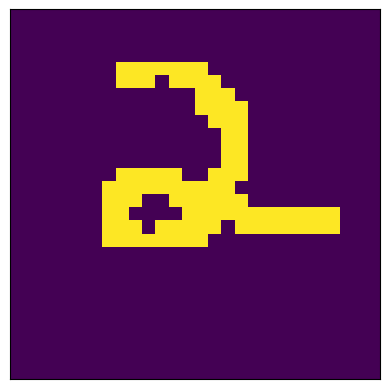

[[4.1435145e-28 5.0263564e-25 1.0000000e+00 1.3561487e-16 1.1286234e-22
  4.8639381e-22 1.7556762e-24 7.3789220e-21 1.5801811e-21 1.3718747e-21]]


In [20]:
# test 2d inverted
image_predict = model.predict(test_2d_inv, verbose=0)
print("Predicted Label: ", np.argmax(image_predict))
plt.imshow(np.squeeze(test_2d_inv))
plt.xticks([])
plt.yticks([])
plt.show()
print(image_predict)

Predicted Label:  3


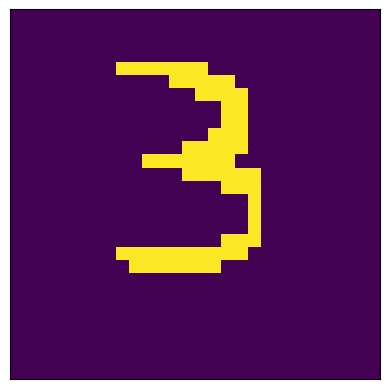

[[2.3917563e-31 6.0828207e-25 4.9765299e-22 1.0000000e+00 4.1816752e-26
  1.1295290e-20 7.4537076e-25 4.1951274e-19 5.8155662e-19 1.5394792e-19]]


In [21]:
# test 3d inverted
image_predict = model.predict(test_3d_inv, verbose=0)
print("Predicted Label: ", np.argmax(image_predict))
plt.imshow(np.squeeze(test_3d_inv))
plt.xticks([])
plt.yticks([])
plt.show()
print(image_predict)

Predicted Label:  4


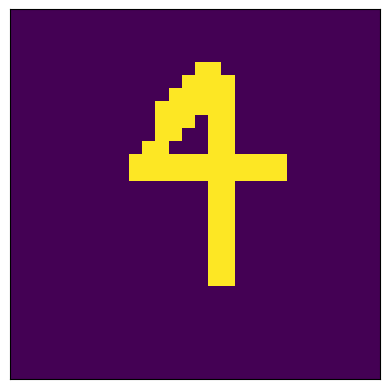

[[2.7745028e-19 7.9322389e-13 8.1404406e-14 7.0696953e-13 1.0000000e+00
  1.4855838e-14 4.0896143e-16 9.7989472e-10 7.3665428e-11 2.3990371e-10]]


In [22]:
# test 4d inverted
image_predict = model.predict(test_4d_inv, verbose=0)
print("Predicted Label: ", np.argmax(image_predict))
plt.imshow(np.squeeze(test_4d_inv))
plt.xticks([])
plt.yticks([])
plt.show()
print(image_predict)

Predicted Label:  5


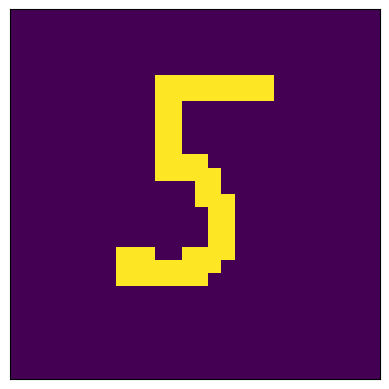

[[9.8350713e-28 9.1140343e-24 7.5833396e-26 5.6345765e-19 1.1567673e-24
  1.0000000e+00 1.2652703e-17 1.2985083e-21 3.2217718e-19 1.6712912e-21]]


In [23]:
# test 5d inverted
image_predict = model.predict(test_5d_inv, verbose=0)
print("Predicted Label: ", np.argmax(image_predict))
plt.imshow(np.squeeze(test_5d_inv))
plt.xticks([])
plt.yticks([])
plt.show()
print(image_predict)

Predicted Label:  6


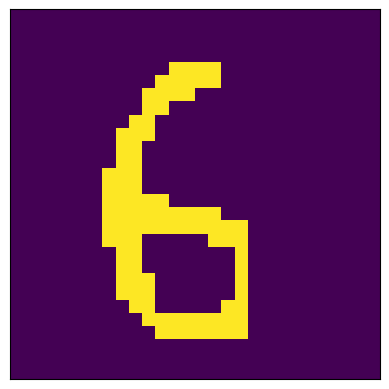

[[1.26190907e-08 1.07469106e-07 4.74054059e-06 1.20207688e-09
  1.92902121e-08 9.83013933e-07 9.99992371e-01 3.31112560e-08
  1.81184703e-06 4.31987912e-09]]


In [24]:
# test 6d inverted
image_predict = model.predict(test_6d_inv, verbose=0)
print("Predicted Label: ", np.argmax(image_predict))
plt.imshow(np.squeeze(test_6d_inv))
plt.xticks([])
plt.yticks([])
plt.show()
print(image_predict)

Predicted Label:  7


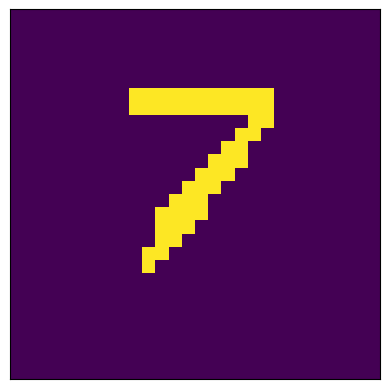

[[1.0331391e-20 2.5652554e-16 2.9078250e-12 9.6900647e-11 6.9510938e-17
  1.7133178e-14 8.5856828e-17 1.0000000e+00 2.0424301e-18 3.5299759e-16]]


In [25]:
# test 7d inverted
image_predict = model.predict(test_7d_inv, verbose=0)
print("Predicted Label: ", np.argmax(image_predict))
plt.imshow(np.squeeze(test_7d_inv))
plt.xticks([])
plt.yticks([])
plt.show()
print(image_predict)

Predicted Label:  8


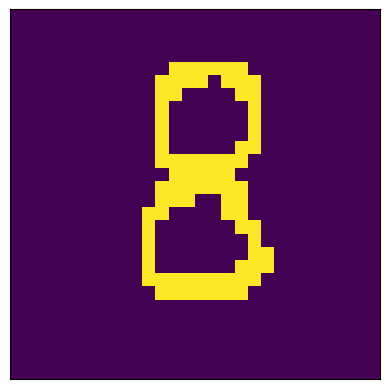

[[3.5549502e-23 2.8479305e-23 5.8634615e-18 2.1718490e-20 9.4330863e-25
  4.4906093e-21 5.3260240e-20 1.0259044e-21 1.0000000e+00 9.7073503e-17]]


In [26]:
# test 8d inverted
image_predict = model.predict(test_8d_inv, verbose=0)
print("Predicted Label: ", np.argmax(image_predict))
plt.imshow(np.squeeze(test_8d_inv))
plt.xticks([])
plt.yticks([])
plt.show()
print(image_predict)

Predicted Label:  9


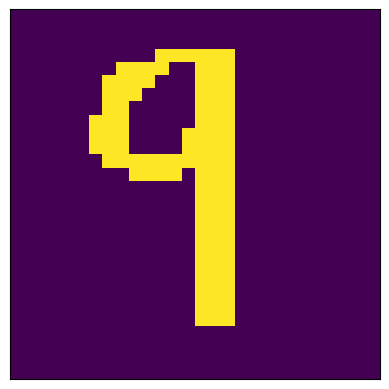

[[3.9094086e-13 9.4017185e-09 7.0120021e-11 2.4930703e-13 1.0532793e-02
  7.8045025e-13 1.4161086e-15 7.9886270e-08 2.4292029e-10 9.8946708e-01]]


In [27]:
# test 9d inverted
image_predict = model.predict(test_9d_inv, verbose=0)
print("Predicted Label: ", np.argmax(image_predict))
plt.imshow(np.squeeze(test_9d_inv))
plt.xticks([])
plt.yticks([])
plt.show()
print(image_predict)

In [30]:
# lets export our model
model.save("best.keras")